# Cheat sheet - Option Pricing with Black-Scholes
François Goujon

Content : Implementation of Black-Scholes option pricing model with analytical and monte-carlo computations. Option pricing, implied vol and greeks. Application on real data.

## Black-Scholes : 

$Call = S \mathcal{N}(d_1) - e^{-rT}K \mathcal{N}(d_2)$ <br>
$Put = - S \mathcal{N}(-d_1) + e^{-rT}K \mathcal{N}(-d_2)$

Where : $d_1 = \frac{1}{\sigma\sqrt{T}} (\log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t) \ $ and $ \ d_2 = d_1 - \sigma\sqrt{T}$

### Table of Contents

* [Analytical](#analytical)
    * [Functions](#ana_func)
    * [Use cases](#ana_uc)
        * [Option pricing](#ana_op)
        * [Implied vol](#ana_iv)
        * [Parameters influence](#ana_pi)
        * [Greeks](#ana_greeks)
        * [Call-put parity](#ana_cpp)
        * [Structured payoff](#ana_sp)
    
* [Monte-Carlo](#mc)
    * [Functions](#mc_func)
    * [Use cases](#mc_uc)
    
* [Application on real data](#app)
    * [Function](#app_func)
    * [Use cases](#app_uc)
        * [APPL option estimation](#app_oe)
        * [Comparison with market prices](#app_mp)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy as sc
import datetime

## Analytical : <a class="anchor" id="analytical"></a>
### Functions <a class="anchor" id="ana_func"></a>

In [10]:
def d1(s, k, sigma, t, r):
    """
    Computes d1 in BS model
    
    Inputs:
    - s0: spot (initial underlying asset price)
    - k: strike
    - sigma: volatility of underlying
    - t: time to maturity
    - r: risk free rate

    Output:
    - d1
    """
    return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))

def d2(s, k, sigma, t, r):
    """
    Computes d2 in BS model
    """
    return d1(s, k, sigma, t, r) - sigma*np.sqrt(t)

def call(s, k, sigma, t, r):
    """
    Computes call premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return s*norm.cdf(d1_) - k*np.exp(-r*t)*norm.cdf(d2_)

def put(s, k, sigma, t, r):
    """
    Computes put premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def pdi(s, k, b, sigma, t, r):
    """
    Computes put down in premium with BS model
    """
    d1_ = d1(s, b, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def proba_ITM(s, k, sigma, t, r, option="call"):
    """
    Computes probability of option ITM : 
    Call : S_T > K ; Put : S_T < K
    """
    d2_ = d2(s, k, sigma, t, r)
    if option == "call":
        return norm.cdf(d2_)
    elif option == "put":
        return norm.cdf(-d2_)
    else:
        print("Option not supported")

def compute_delta(s, k, sigma, t, r, option="call"):
    d1_ = d1(s, k, sigma, t, r)
    if option == "call":
        return norm.cdf(d1_)
    elif option == "put":
        return -norm.cdf(-d1_)
    elif option == "both":
        return np.array([norm.cdf(d1_), -norm.cdf(-d1_)]).T
    else:
        print("Option not supported")
        
def compute_vega(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    vega = s*norm.pdf(d1_)*np.sqrt(t)*0.01
    return vega

def compute_gamma(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    gamma = norm.pdf(d1_)/(s*sigma*np.sqrt(t))
    return gamma

def compute_rho(s, k, sigma, t, r, option="call"):
    d2_ = d2(s, k, sigma, t, r)
    if option == "call":
        rho = k*t*np.exp(-r*t)*norm.cdf(d2_)*0.01
        return rho
    elif option == "put":
        rho = -k*t*np.exp(-r*t)*norm.cdf(-d2_)*0.01
        return rho
    elif option == "both":
        rho_c = k*t*np.exp(-r*t)*norm.cdf(d2_)*0.01
        rho_p = -k*t*np.exp(-r*t)*norm.cdf(-d2_)*0.01
        return np.array([rho_c, rho_p]).T
    else:
        print("Option not supported")
        
def compute_theta(s, k, sigma, t, r, option="call"):
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    if option == "call":
        theta = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) - r*k*np.exp(-r*t)*norm.cdf(d2_)
        return theta
    elif option == "put":
        theta = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) + r*k*np.exp(-r*t)*norm.cdf(-d2_)
        return theta
    elif option =="both":
        theta_c = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) - r*k*np.exp(-r*t)*norm.cdf(d2_)
        theta_p = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) + r*k*np.exp(-r*t)*norm.cdf(-d2_)
        return np.array([theta_c, theta_p]).T
    else:
        print("Option not supported")
        
def print_greeks(s, k, sigma, t, r, option="call"):
    params = [s, k, sigma, t, r]
    print(f"For the following parameters : S = {s}, K = {k}, Sigma = {sigma}, T = {t}, r = {r}")
    print(f"Delta = {compute_delta(*params, option=option)}")
    print(f"Vega = {compute_vega(*params)}")
    print(f"Gamma = {compute_gamma(*params)}")
    print(f"Rho = {compute_rho(*params, option=option)}")
    print(f"theta = {compute_theta(*params, option=option)}")

def plot_greeks(s0, k, sigma, t, r, option="call"):
    print(f"Option type : {option}")
    print(f"Option parameters: strike = {k} ; vol = {sigma} ; maturity = {t} ; rfr = {r}")
    ss = np.arange(0.5*s0, 1.5*s0, 0.01*s0)
    fig, axs = plt.subplots(3, 2, figsize=(30,20))
    labels = ["Delta", "Vega", "Gamma", "Rho", "Theta"]
    if option == "both": 
        option_lab = ["Call", "Put"]
    else:
        option_lab = [option]
    legend = [[opt + " " + lab for opt in option_lab] for lab in labels]
    axs[0,0].plot(ss, compute_delta(ss, k, sigma, t, r, option=option), label=legend[0])
    axs[0,1].plot(ss, compute_vega(ss, k, sigma, t, r), label=labels[1])
    axs[1,0].plot(ss, compute_gamma(ss, k, sigma, t, r), label=labels[2])
    axs[1,1].plot(ss, compute_rho(ss, k, sigma, t, r, option=option), label=legend[3])
    axs[2,0].plot(ss, compute_theta(ss, k, sigma, t, r, option=option), label=legend[4])
    i = 0
    for ax in axs.flatten()[:-1]:
        ax.set_xlabel("Underlying asset price")
        ax.set_ylabel(labels[i])
        ax.set_title(f"{labels[i]} evolution depending on asset price")
        ax.legend()
        i+=1
    plt.show()

def plot_premium_strike(s, sigma, t, r):
    """
    Plot option premiums depending on strike
    """
    ks = np.arange(0.005*s, 2*s, 0.005*s)
    call_prms = list(map(lambda x : call(s, x, sigma, t, r), ks))
    put_prms = list(map(lambda x : put(s, x, sigma, t, r), ks))
    plt.figure(figsize=(12,6))
    plt.plot(ks, call_prms, label='Call premium', c = "g")
    plt.plot(ks, put_prms, label='Put premium', c = "r")
    plt.axvline(x=s, c="b", label = "S0")
    plt.xlabel("Strike")
    plt.ylabel("Premium")
    plt.legend()
    plt.grid()
    plt.show()
    return ks, call_prms, put_prms

def plot_vol_bs(s0, r, k, t):
    """
    Plot the option premium depending on volatility for the chosen parameters

    Inputs:
    - s0: initial asset price
    - r: risk free rate
    - k: strike price
    - t: time of simulation in years
    - m: number of simulations in MC
    
    Outputs:
    - sigmas: volatilities
    - calls, puts: option premium for the different theta values
    """
    sigmas = np.arange(0.001, 0.7, 0.001)
    calls = call(s0, k, sigmas, t, r)
    puts = put(s0, k, sigmas, t, r)

    fig, axs = plt.subplots(2, 2, figsize=(24,10))
    axs[0,0].plot(sigmas, calls, label="Calls")
    axs[0,0].set_title("Implied volatility (std) Calls")
    axs[1,0].plot(sigmas[:350], calls[:350], label="Calls")
    axs[0,1].plot(sigmas, puts, label="Puts")
    axs[0,1].set_title("Implied volatility (std) Puts")
    axs[1,1].plot(sigmas[:350], puts[:350], label="Puts")
    for ax in axs.flatten():
        ax.set_xlabel("Volatility (std)")
        ax.set_ylabel("Option premium")
        ax.legend()
    plt.show()
    
    return sigmas, calls, puts

def plot_parameters_influence(s0, k0, sig0 = 0.17, t0 = 1, r0 = 0.01):
    ss = np.arange(0.2*s0, 2*s0, 0.05*s0)
    calls_ss = call(ss, k0, sig0, t0, r0)
    puts_ss = put(ss, k0, sig0, t0, r0)
    ks = np.arange(0.2*k0, 2*k0, 0.05*k0)
    calls_ks = call(s0, ks, sig0, t0, r0)
    puts_ks = put(s0, ks, sig0, t0, r0)
    sigmas = np.arange(0.001, 0.7, 0.001)
    calls_sigmas = call(s0, k0, sigmas, t0, r0)
    puts_sigmas = put(s0, k0, sigmas, t0, r0)
    ts = np.arange(0.1, 10, 0.1)
    calls_ts = call(s0, k0, sig0, ts, r0)
    puts_ts = put(s0, k0, sig0, ts, r0)
    rs = np.arange(0.001, 0.1, 0.01)
    calls_rs = call(s0, k0, sig0, t0, rs)
    puts_rs = put(s0, k0, sig0, t0, rs)
    labels = ["spot", "strike", "volatility", "maturity", "rfr"]
    print(f"Default values : spot = {s0} ; strike = {k0} ; vol = {sig0} ; maturity = {t0} ; rfr = {r0}")

    fig, axs = plt.subplots(3, 2, figsize=(30,20))
    axs[0,0].plot(ss, calls_ss, label="Calls")
    axs[0,1].plot(ks, calls_ks, label="Calls")
    axs[1,0].plot(sigmas, calls_sigmas, label="Calls")
    axs[1,1].plot(ts, calls_ts, label="Calls")
    axs[2,0].plot(rs, calls_rs, label="Calls")
    axs[0,0].plot(ss, puts_ss, label="Puts")
    axs[0,1].plot(ks, puts_ks, label="Puts")
    axs[1,0].plot(sigmas, puts_sigmas, label="Puts")
    axs[1,1].plot(ts, puts_ts, label="Puts")
    axs[2,0].plot(rs, puts_rs, label="Puts")
    i = 0
    for ax in axs.flatten()[:-1]:
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Option premium")
        ax.set_title(f"Option premium depending on {labels[i]}")
        ax.legend()
        i+=1
    plt.show()


def implied_vol(s, k, t, r, market_price, opt_type = "call", clean=True, clean_tolerance=3):
    """Computes implied volatility for a given option
    If k: number and market_price: number : implied vol for this couple
    If k: number and market_price: list : implied vol for every price of the list
    If k: list and market_price: list : implied vol for every couple strike, premium"""
    if hasattr(market_price, "__len__"):
        mark_pr = np.array(market_price)
        n = len(mark_pr)
    else:
        mark_pr = np.array([market_price])
        n = 1
    if hasattr(k, "__len__"):
        if len(k) == n :
            ks = np.array(k)
        else:
            raise("k and market_price must be of the same lenght")
    else:
        ks = k
        
    def diff_price_call(sigma):
        vol = np.array(sigma)
        return sum(abs(mark_pr - call(s, ks, vol, t, r)))
    def diff_price_put(sigma):
        vol = np.array(sigma)
        return sum(abs(mark_pr - put(s, ks, vol, t, r)))
    
    constraints_0 = [{"type": "ineq", "fun": lambda x: x[k]} for k in range(n)]
    constraints_1 = [{"type": "ineq", "fun": lambda x: 1-x[k]} for k in range(n)]
    constraints = constraints_0 + constraints_1
    x0 = 0.5*np.ones(n)
    if opt_type == "call":
        opt = sc.optimize.minimize(fun=diff_price_call, x0=x0, constraints=constraints)
    elif opt_type == "put":
        opt = sc.optimize.minimize(fun=diff_price_put, x0=x0, constraints=constraints)
    else:
        raise("Option type not supported")

    if n==1:
        return opt.x[0]
    else:
        res = opt.x
        # Clean errors
        if clean:
            res[res<0] = np.nan
            res[res>1] = np.nan
            mean = np.nanmean(res)
            std = np.nanstd(res)
            res[np.abs(res-mean) > clean_tolerance*std] = np.nan
        return res

def plot_implied_vol_bs(s0, sigma, t, r, clean=True):
    """
    Plot i depending on strike
    
    Inputs:
    - s0: initial asset price
    - sigma: volatility
    - r: risk free rate
    - T: time to maturity
    """
    # Set strikes 
    ks = np.arange(0.8*s0, 1.2*s0, 0.02*s0)
    
    calls = call(s0, ks, sigma, t, r)
    puts = put(s0, ks, sigma, t, r)
    
    put_impvol = implied_vol(s0, ks, t, r, puts, opt_type = "put", clean=clean) 
    call_impvol = implied_vol(s0, ks, t, r, calls, opt_type = "call", clean=clean)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(26, 6))
    ax1.plot(ks, calls, label="Call premiums")
    ax1.plot(ks, puts, label="Put premiums")
    ax1.set_ylabel("Premium")
    ax1.set_xlabel("Strike")
    ax1.set_title("Option premium under BS Model")
    ax1.legend()
    ax2.plot(ks, call_impvol, label="Implied Vol Calls")
    ax2.plot(ks, put_impvol, label="Implied Vol Puts")
    ax2.set_ylabel("Implied vol")
    ax2.set_xlabel("Strike")
    ax2.set_title("Implied vol under BS Model")
    ax2.set_ylim(0, 0.5)
    ax2.legend()
    plt.show()

def plot_payoff(s, k, sigma, t, r, ret = False):
    """
    Plot payoff of options of t = T
    """
    pc = call(s, k, sigma, t, r)
    pp = put(s, k, sigma, t, r)
    pc_T = pc*np.exp(r*t)
    pp_T = pp*np.exp(r*t)
    
    sts = np.arange(0, 2*s, 0.005*s)
    call_po = np.array(list(map(lambda x : max(x-k,0) - pc_T, sts)))
    put_po = np.array(list(map(lambda x : max(k-x,0) - pp_T, sts)))
    call_put = call_po - put_po
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 15))
    ax1.plot(sts, call_po, label = "Payoff call", c = "g")
    ax1.plot(sts, put_po, label = "Payoff put", c = "r")
    ax2.plot(sts, call_put, label = "Call - Put payoff", c = "black")
    ax2.plot(sts, call_po, label = "Call payoff", c = "g")
    ax2.plot(sts, -put_po, label = "Put sell payoff", c = "r")
    for ax in [ax1, ax2]:
        ax.axvline(x=s, c="b", label = "S0")
        ax.axvline(x=k, c="deeppink", label = "K")
        ax.set_xlabel(r"$S_T$")
        ax.set_ylabel("PF Value at t = T")
        ax.legend()
        ax.grid()
    plt.show()
    if ret:
        return sts, call_po, put_po, call_put
    
def plot_structured_payoff(s, products, r, t, with_cost=False, plot_all=False):
    """
    Plot payoff of a structured product composed of options, bonds, asset
    
    Inputs:
    products = [{"name": "bond", "params" : [number]},
                {"name" : "option", "params" : ["call/put", "buy/sell", "strike", "vol"]},
                {"name" : "spot", "params" : [nb]}]
    """
    
    sts = np.arange(0, 2*s, 0.005*s)
    n = len(sts)
    payoffs = []
    premiums = [0]
    costs_bonds = [0]
    costs_spot = [0]
    for prod in products:
        # BOND
        if prod["name"] == "bond":
            nb = prod["params"][0]
            #bond_po = np.exp(-r*t)*nb*np.ones(n) #t=0
            bond_po = nb*np.ones(n) #t=T
            payoffs.append(bond_po)
            costs_bonds.append(nb*np.exp(-r*t))
        
        # OPTION
        elif prod["name"] == "option":
            k = prod["params"][2]
            sigma = prod["params"][3]
            way = 1 if prod["params"][1] == "buy" else -1
            if prod["params"][0] == "call": 
                pc = call(s, k, sigma, t, r)
                call_po = way*np.array(list(map(lambda x : max(x-k,0), sts))) # t=T
                #call_po = way*np.array(list(map(lambda x : max(np.exp(-r*t)*(x-k),0), sts))) #t=0
                payoffs.append(call_po)
                premiums.append(way*pc)
            elif prod["params"][0] == "put": 
                pp = put(s, k, sigma, t, r)
                put_po = way*np.array(list(map(lambda x : max(k-x,0), sts))) #t=T
                #put_po = way*np.array(list(map(lambda x : max(np.exp(-r*t)*(k-x),0), sts))) #t=0
                payoffs.append(put_po)
                premiums.append(way*pp)
            else:
                print("Option type not supported")
        
        # Spot
        elif prod["name"] == "spot":
            nb = prod["params"][0]
            #spot_po = np.exp(-r*t)*nb*sts # t=0
            spot_po = nb*sts # t=T
            payoffs.append(spot_po)
            costs_spot.append(nb*s)
            
        else:
            print("Product type not supported")
            
    sum_po = np.array(payoffs).sum(axis=0)
    ct_pr = sum(premiums)
    ct_bd = sum(costs_bonds)
    ct_sp = sum(costs_spot)
    total_cost = ct_pr + ct_bd + ct_sp
    total_cost_actualized = total_cost*np.exp(r*t)
    if with_cost:
        sum_po -= total_cost_actualized
    plt.figure(figsize=(12,6))
    plt.plot(sts, sum_po, label='PF Value', c = "black")
    if plot_all:
        for po in payoffs:
            plt.plot(sts, po)
    plt.xlabel(r"$S_T$ at t = T")
    plt.ylabel("PF Value at t = T")
    plt.title("Structured Payoff")
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"Total premium paid (at t=0): {ct_pr}")
    print(f"Total bond cost (at t=0): {ct_bd}")
    print(f"Total spot cost (at t=0): {ct_sp}")
    print(f"Total initial cost (at t=0): {total_cost}")
    print(f"Total initial cost (actualized at t=T): {total_cost_actualized}")
            
    return sts, payoffs, sum_po

## Use cases <a class="anchor" id="ana_uc"></a>

### Option pricing : <a class="anchor" id="ana_op"></a>

In [21]:
S0 = 100 # Spot price
K = 100  # Strike price
T = 1     # Time to maturity in years
r = 0.01  # Risk-free rate
sigma = 0.17 # Volatility 
params = [S0, K, sigma, T, r]

In [5]:
# Premium of put with given params
put(*params)

12.398133147893589

In [22]:
# Premium of call with given params
call(*params)

7.249298366090024

In [7]:
# Also works with an array of strikes
call(S0, np.array([110, 120, 130]), sigma, T, r)

array([3.49265144, 1.50061887, 0.58397675])

In [8]:
# Or an array of volatilities (also works with array of spot, array of rfr, array of maturity)
call(S0, 110, np.array([0.17, 0.20, 0.23, 0.26]), T, r)

array([3.49265144, 4.61011457, 5.75746129, 6.92391962])

In [9]:
# With both as array it will zip parameters together : (strike, vol) couple
call(S0, np.array([110, 120, 130]), np.array([0.17, 0.20, 0.23]), T, r)

array([3.49265144, 2.3406494 , 1.7925404 ])

### Implied Vol <a class="anchor" id="ana_iv"></a>

In [10]:
# Multiple premiums for same parameters except volatility : give implied vol for each premium
implied_vol(S0, K, T, r, [3.49, 4.61, 5.76, 6.92], opt_type = "call")

array([0.1699076 , 0.19999462, 0.23006575, 0.25990367])

In [11]:
# To draw volatility smile : volatilities for (strike, premium) couple
implied_vol(S0, [110, 120, 130], T, r, [3.49, 2.34, 1.79], opt_type = "call")

array([0.16992754, 0.19997827, 0.22989725])

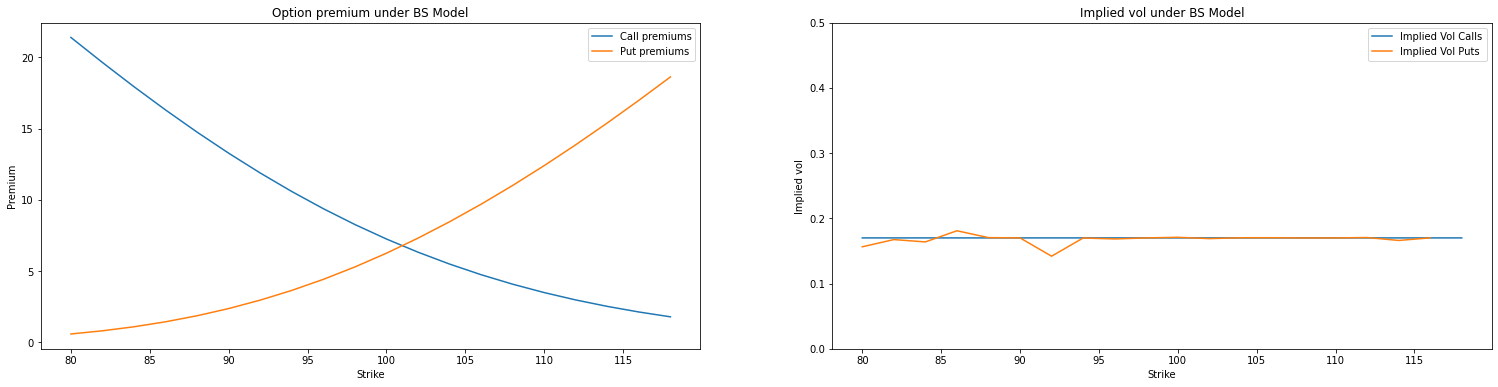

In [12]:
plot_implied_vol_bs(S0, sigma, T, r) # Implied vol flat at 0.17 as expected.

### Parameters influence <a class="anchor" id="ana_pi"></a>

Default values : spot = 100 ; strike = 101 ; vol = 0.17 ; maturity = 1 ; rfr = 0.01


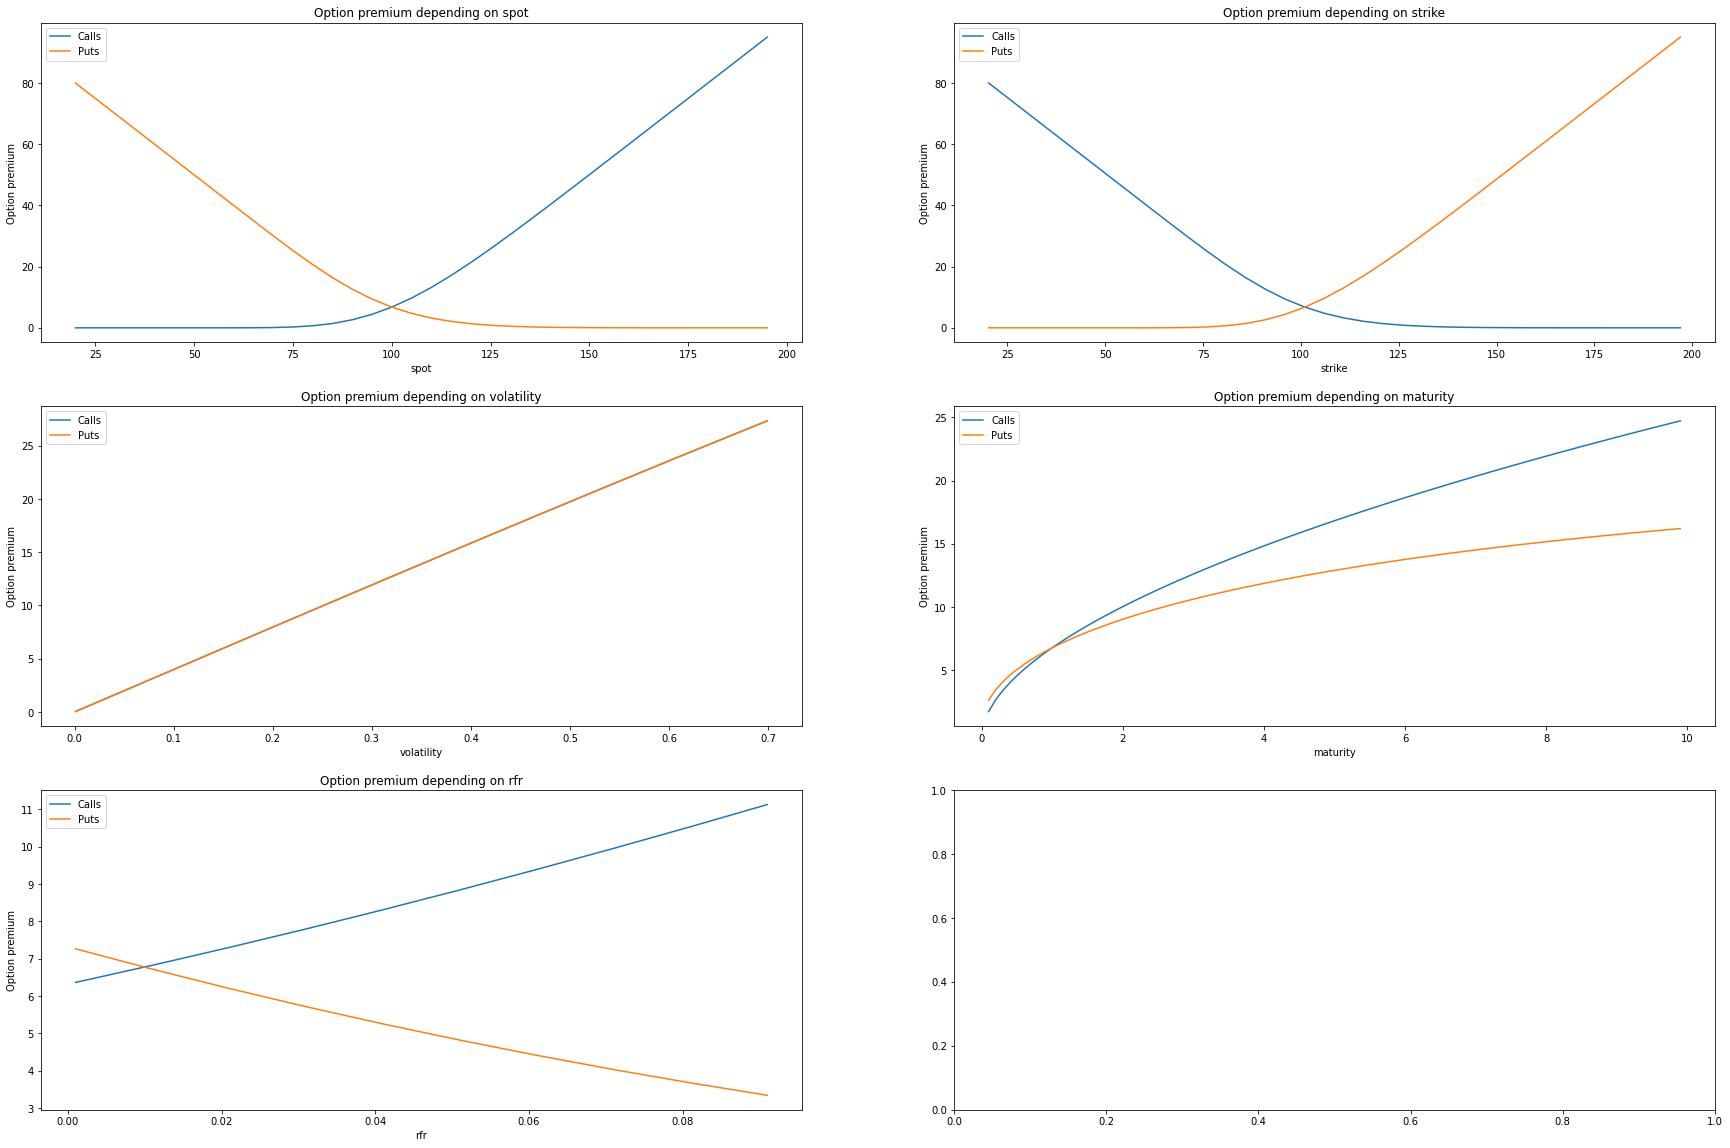

In [5]:
plot_parameters_influence(100, 101, sigma, T, r)

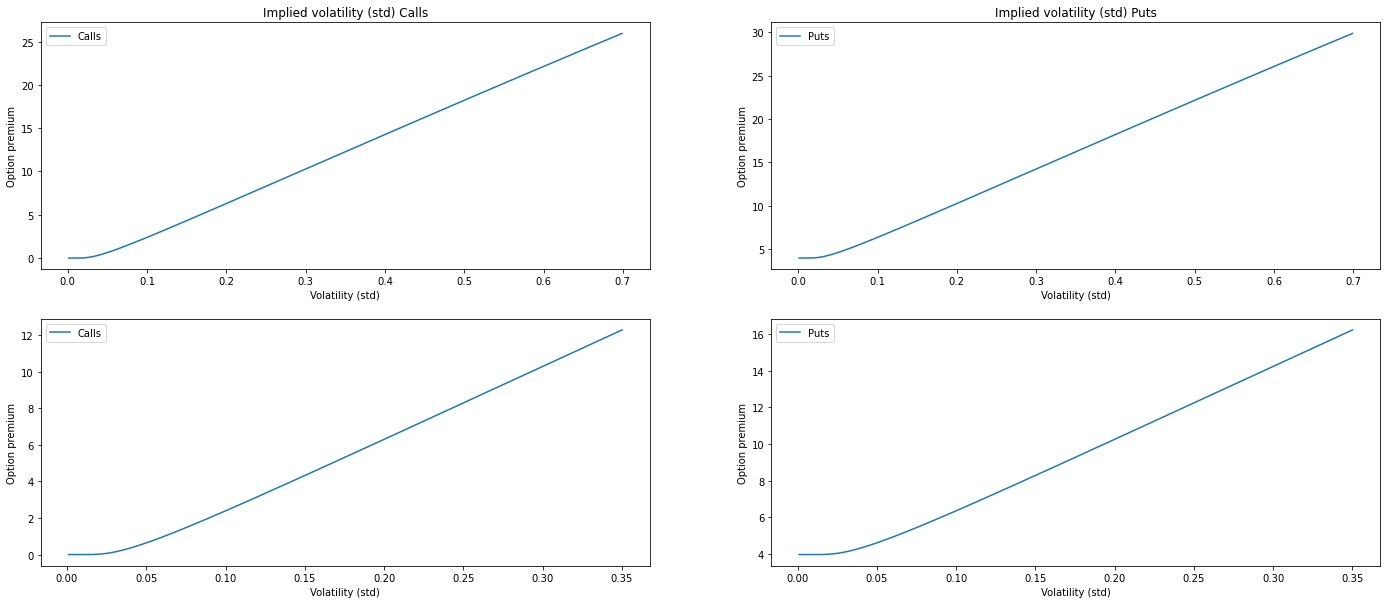

In [15]:
a,b,c = plot_vol_bs(S0, r, K, T)

### Greeks <a class="anchor" id="ana_greeks"></a>

In [13]:
# Print greeks for given parameters
print_greeks(np.array([100, 110, 120]), K, sigma, T, r, "call")

For the following parameters : S = [100 110 120], K = 110, Sigma = 0.17, T = 1, r = 0.01
Delta = [0.33840336 0.55718009 0.74397699]
Vega = [0.36574829 0.43432119 0.38613863]
Gamma = [0.02151461 0.0211143  0.01577364]
Rho = [0.30347684 0.53315582 0.74752087]
theta = [-3.41233735 -4.2248859  -4.02969925]


Option type : both
Option parameters: strike = 110 ; vol = 0.17 ; maturity = 1 ; rfr = 0.01


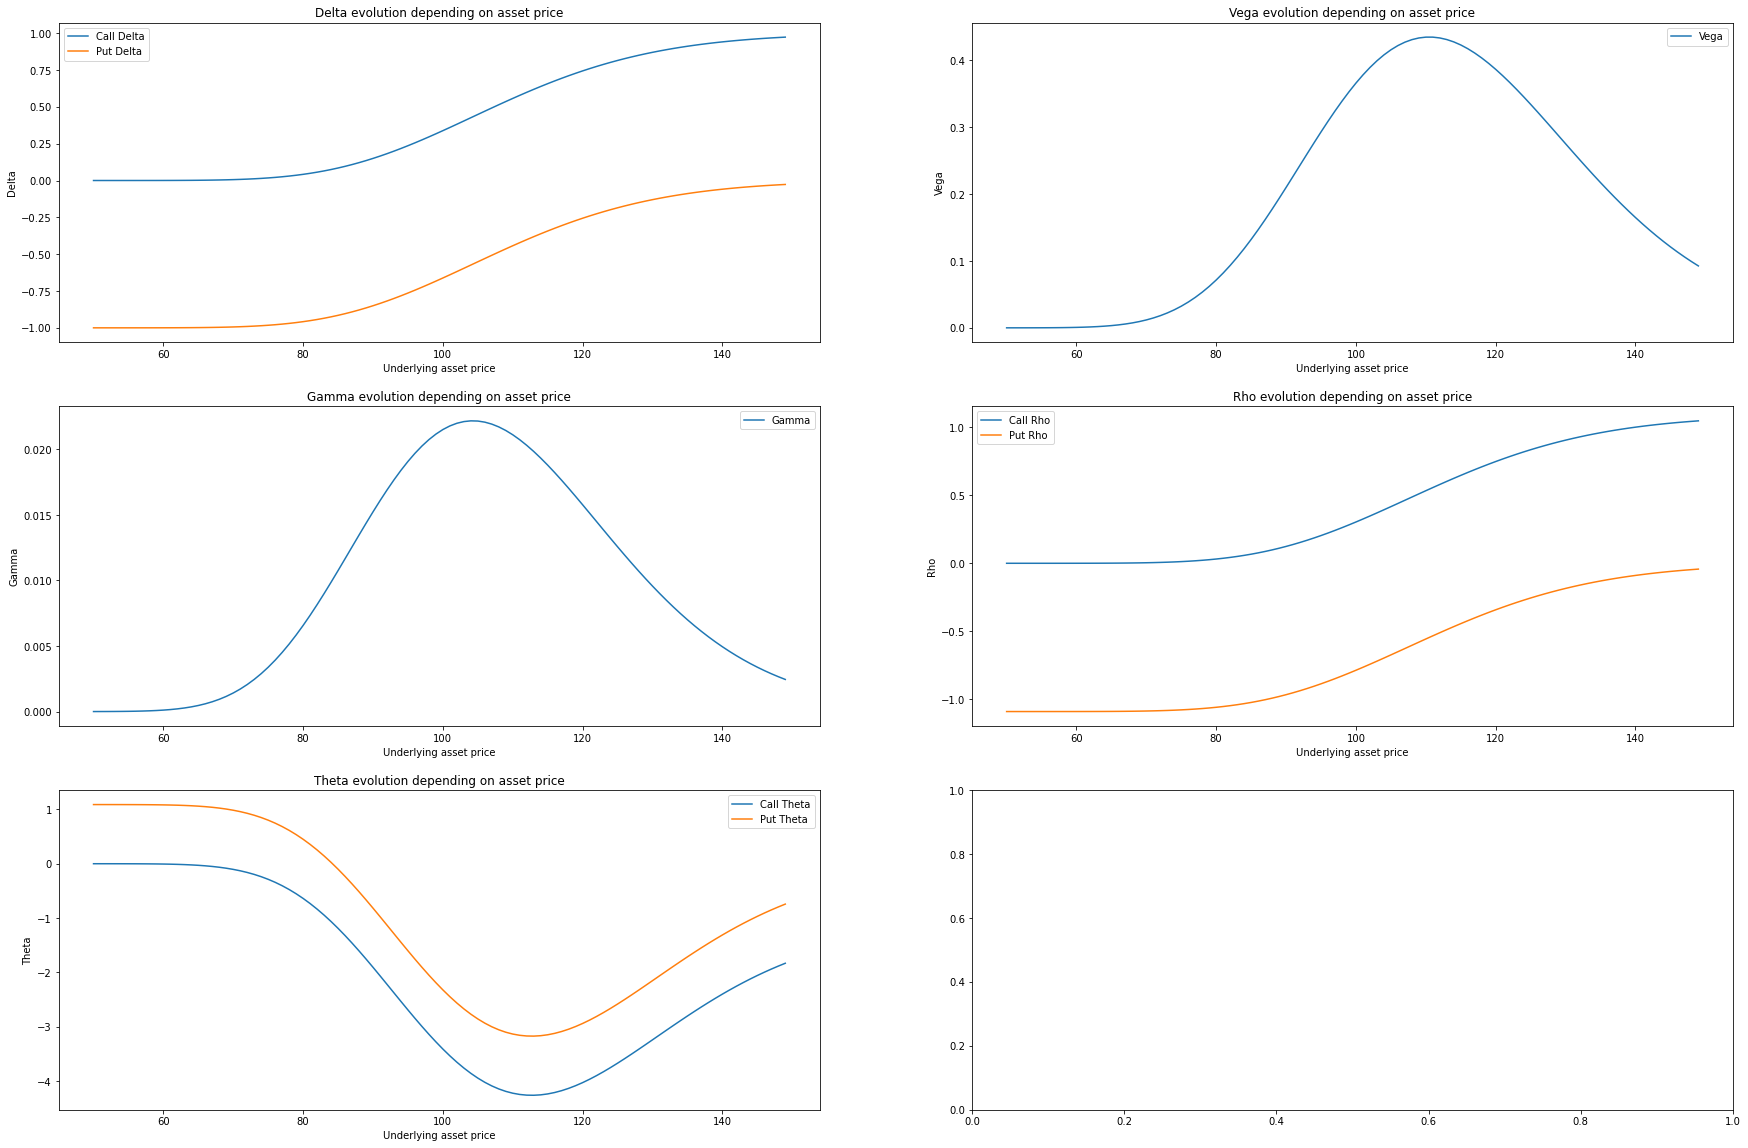

In [14]:
# Plot greeks evolution depending on underlying asset price
plot_greeks(S0, K, sigma, T, r, option="both")

## Call-put parity  : <a class="anchor" id="ana_cpp"></a>
$C - P = S - Ke^{-rT} \quad \Leftrightarrow \quad C + Ke^{-rT} = S + P$

In [16]:
print(call(*params) - put(*params))
print(S0 - K*np.exp(-r*T))

-8.905481712408502
-8.905481712408488


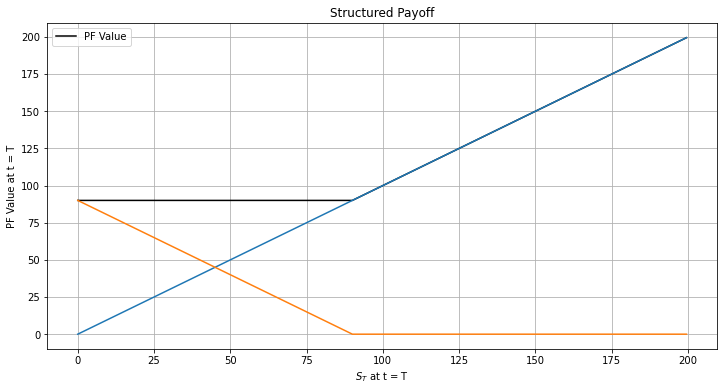

Total premium paid (at t=0): 1.793865773975078
Total bond cost (at t=0): 0
Total spot cost (at t=0): 100
Total initial cost (at t=0): 101.79386577397509
Total initial cost (actualized at t=T): 102.8169111331469


In [12]:
products = [{"name" : "spot", "params" : [1]},
           {"name" : "option", "params" : ["put", "buy", 90, sigma]}]
a, b, c = plot_structured_payoff(S0, products, r, T, False, True)

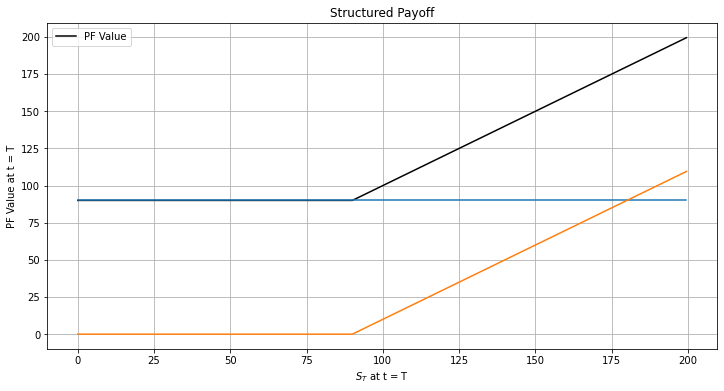

Total premium paid (at t=0): 12.689380736549936
Total bond cost (at t=0): 89.10448503742514
Total spot cost (at t=0): 0
Total initial cost (at t=0): 101.79386577397507
Total initial cost (actualized at t=T): 102.81691113314689


In [13]:
products = [{"name" : "bond", "params" : [90]},
           {"name" : "option", "params" : ["call", "buy", 90, sigma]}]
a,b,c = plot_structured_payoff(S0, products, r, T, False, True)

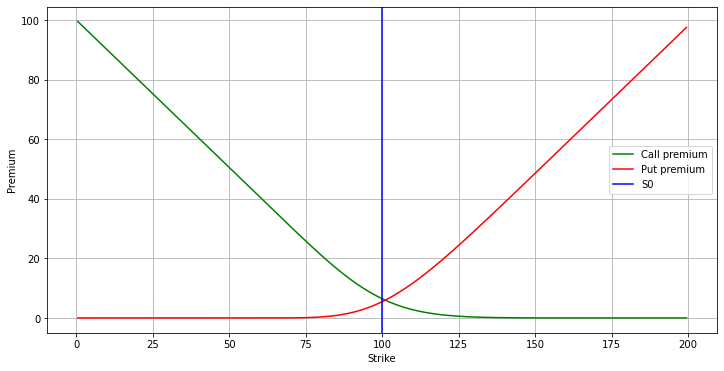

In [10]:
a, b, c = plot_premium_strike(S0, sigma, T, r)

$C = P \Rightarrow K = Se^{rT} = F > S$ : for the same price you have an ITM put and an OTM call

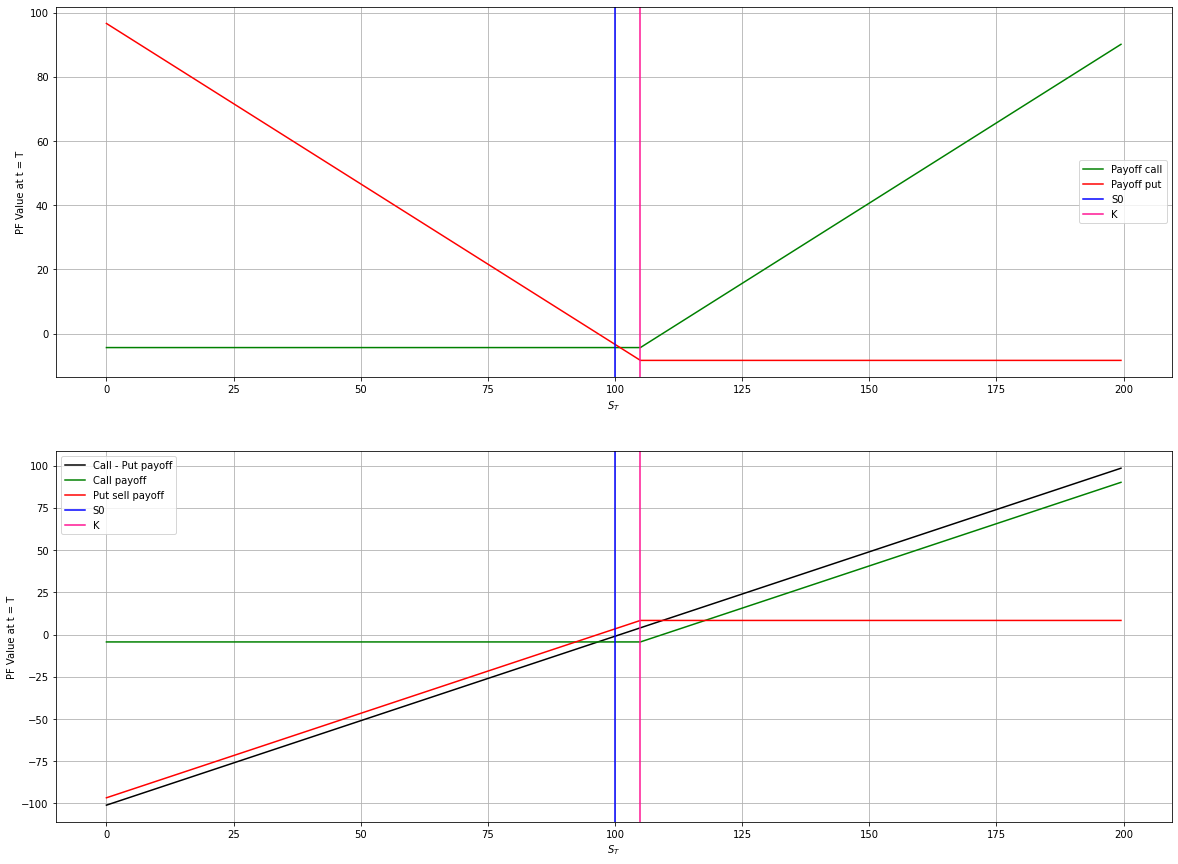

In [11]:
a,b,c,d = plot_payoff(S0, K, sigma, T, r, True)

At $t = 0$ : $V_{t=0} = P - C = e^{-rT}K - S_0 \ (= e^{rT}(P - C) = K - e^{rT}S_0)_{t=T}$ (Sell a put, buy a call) <br>
At $t = T$ : $V_{t=T} = S_T - K$ <br>
So all in all : $V_{t=T} = S_T - K + e^{rT}(P - C) = S_T - e^{rT}S_0 = S_T - F_T$ with $F_T$ the futures value of S at maturity T <br>
Selling a put and buying a call is the same as buying a future

## Structured payoff : <a class="anchor" id="ana_sp"></a>

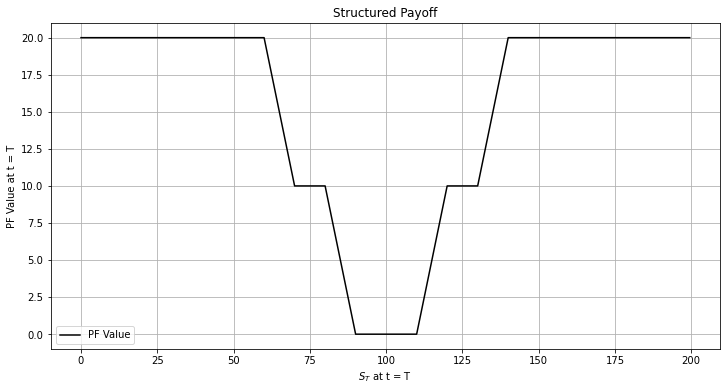

Total premium paid (at t=0): 3.4672916298407928
Total bond cost (at t=0): 0
Total spot cost (at t=0): 0
Total initial cost (at t=0): 3.4672916298407928
Total initial cost (actualized at t=T): 3.5021384900502297


In [14]:
products = [{"name" : "option", "params" : ["put", "buy", 90, sigma]}, 
            {"name" : "option", "params" : ["put", "sell", 80, sigma]},
            {"name" : "option", "params" : ["put", "buy", 70, sigma]}, 
            {"name" : "option", "params" : ["put", "sell", 60, sigma]},
            {"name" : "option", "params" : ["call", "buy", 110, sigma]},
            {"name" : "option", "params" : ["call", "sell", 120, sigma]},
            {"name" : "option", "params" : ["call", "buy", 130, sigma]},
            {"name" : "option", "params" : ["call", "sell", 140, sigma]}]
a,b,c = plot_structured_payoff(100, products, r, T, False, False)


## Monte Carlo Simulation <a class="anchor" id="mc"></a>

### Price evolution under risk-neutral measure (black-scholes):
$$
\frac{dS_t}{S_t} = rdt + \sigma dW_t = rdt + \sqrt{v} dW_t \\
With \ Y_t = \ln(S_t) \ and \ Ito \rightarrow dY_t = \frac{\partial ln}{\partial x}(S_t)dS_t + \frac{1}{2}\frac{\partial^{2} ln}{\partial x^2}(S_t)d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{1}{2S_t^2}d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{v}{2}dt\\
\quad \\
dY_t = (r - \frac{v}{2})dt + \sqrt{v}dW_t \Rightarrow Y_t = Y_0 + (r - \frac{v}{2})t + \sqrt{v}W_t \\
S_t = e^{Y_t} \Rightarrow S_t = S_{0}e^{(r - \frac{\sigma^2}{2})t + \sigma W_t} = S_{0}e^{(r - \frac{v}{2})t + \sqrt{v}W_t} \quad and \ W_t \sim N(0,t)
$$

### Functions <a class="anchor" id="mc_func"></a>

In [26]:
def bs_model_mc(s0, r, theta, t, m):
    """
    Computes Black-Scholes model simulations for the chosen parameters
    
    Inputs:
    - s0: initial underlying asset price (spot)
    - r: risk free rate
    - theta: variance 
    - t: time to maturity in years
    - m: number of simulations
    
    Outputs:
    - Asset price at maturity (numpy array)
    """
    s = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
    return s

def vol_bs_mc(s0, r, k, t, m):
    """
    Plot the option premium depending on volatility for the chosen parameters

    Inputs:
    - s0: initial asset price
    - r: risk free rate
    - k: strike price
    - t: time of simulation in years
    - m: number of simulations in MC
    
    Outputs:
    - thetas: volatilities
    - calls, puts: option premium for the different theta values
    """
    stds = np.arange(0, 0.7, 0.001)
    thetas = stds**2
    ss = [s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m)) for theta in thetas]

    puts = [np.exp(-r*t)*np.mean(np.maximum(k-s, 0)) for s in ss]
    calls = [np.exp(-r*t)*np.mean(np.maximum(s-k, 0)) for s in ss]

    fig, axs = plt.subplots(2, 2, figsize=(24,10))
    axs[0,0].plot(stds, calls, label="Calls")
    axs[0,0].set_title("Volatility (std) Calls")
    axs[1,0].plot(stds[:350], calls[:350], label="Calls")
    axs[0,1].plot(stds, puts, label="Puts")
    axs[0,1].set_title("Volatility (std) Puts")
    axs[1,1].plot(stds[:350], puts[:350], label="Puts")
    for ax in axs.flatten():
        ax.set_xlabel("Volatility (std)")
        ax.set_ylabel("Option premium")
        ax.legend()
    plt.show()
    
    return thetas, calls, puts

def plot_bs_mc(s0, s, r, t):
    """
    Plot premium depending on strike and implied vol depending on strike
    
    Inputs:
    - s0: initial asset price
    - s: asset price at maturity
    - r: risk free rate
    - T: time to maturity
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.005*s0, 2*s0, 0.005*s0)

    puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s, 0)) for k in ks]) # Mean of difference only at maturity
    calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s-k, 0)) for k in ks])

    n = len(ks)
    start = int(n/4)
    end = int(3*n/4)
    reduced_ks = ks[start:end:4]
    reduced_puts = puts[start:end:4]
    reduced_calls = calls[start:end:4]
    
    print("Calculating implied volatilities")
    put_impvol = implied_vol(s0, reduced_ks, t, r, reduced_puts, opt_type = "put", clean_tolerance=2.5)
    print("Puts done")
    call_impvol = implied_vol(s0, reduced_ks, t, r, reduced_calls, opt_type = "call", clean_tolerance=2.5)
    print("Calls done")
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))
    ax1.plot(ks, calls, label="Call premiums", c = "g")
    ax1.plot(ks, puts, label="Put premiums", c = "r")
    ax1.axvline(x=s0, c="b", label = "S0")
    ax1.set_ylabel("Premium")
    ax1.set_xlabel("Strike")
    ax1.set_title("Option premium under BS Model")
    ax1.legend()
    ax1.grid()
    ax2.plot(reduced_ks, call_impvol, label="Implied Vol Calls")
    ax2.plot(reduced_ks, put_impvol, label="Implied Vol Puts")
    ax2.set_ylabel("Implied vol")
    ax2.set_xlabel("Strike")
    ax2.set_title("Implied vol un BS Model")
    ax2.legend()
    plt.show()

### Use cases <a class="anchor" id="mc_uc"></a>

In [30]:
s = bs_model_mc(S0, r, 0.17**2, T, 10000)

Calculating implied volatilities


/var/folders/9s/mnbf7ynj4250m39tyvxgpknw0000gn/T/ipykernel_31892/1673706894.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))


Puts done
Calls done


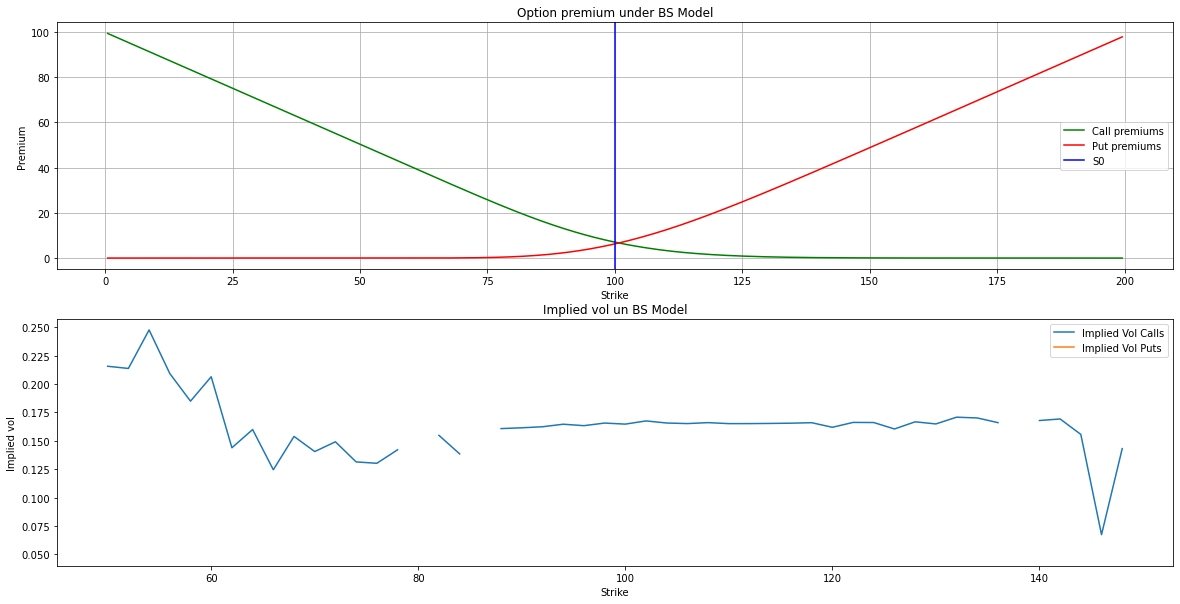

In [31]:
# Monte Carlo
plot_bs_mc(S0, s, r, T)

The premium strike curve is the same as the one calculated with the analytical formula, as intented.

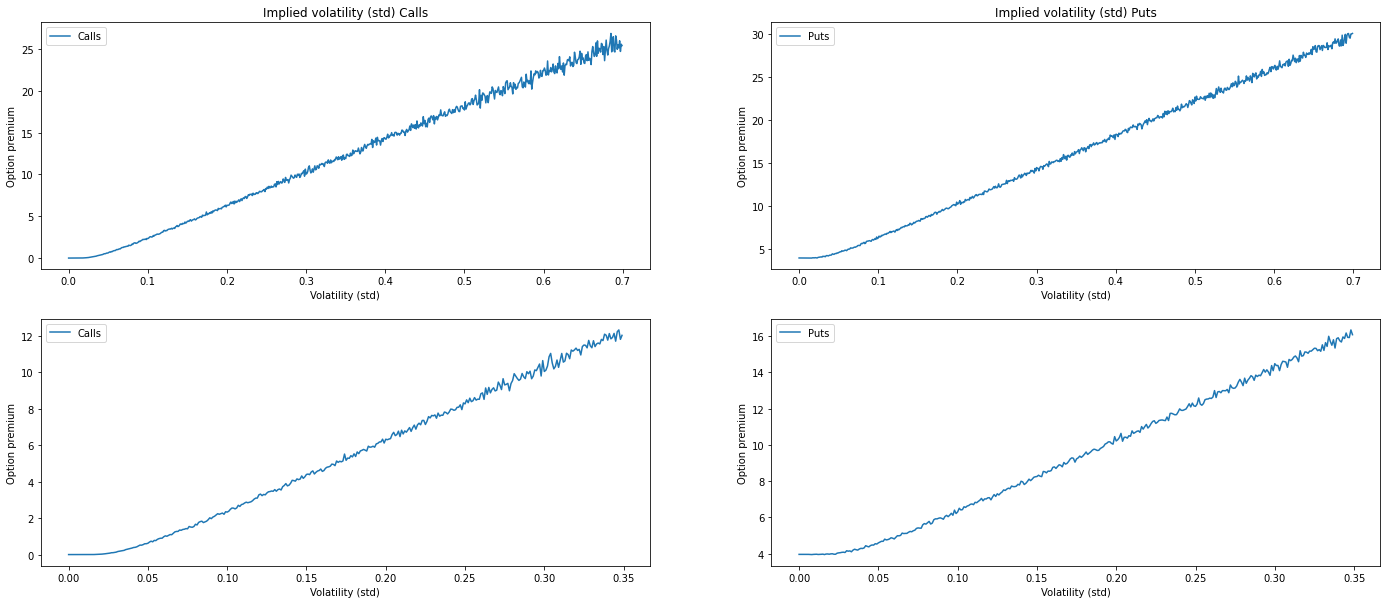

In [21]:
_ = vol_bs_mc(S0, r, K, T, 10000)

## Application on real data <a class="anchor" id="app"></a>

In [5]:
import yfinance as yf
import pandas as pd
import datetime

### Functions <a class="anchor" id="app_func"></a>

In [9]:
def get_data(ticker):
    """
    Retrieve data from yfinance
    Input: ticker (String)
    Output: price dataframe (pd.DataFrame)
    """
    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=10000)
    df = yf.Ticker(ticker).history(start=start, end=end, period="1d")
    df.index = df.index.to_series().dt.date
    return df

def plot_price(data):
    data["Close"].plot(figsize=(12,6))
    plt.show()

def plot_daily_returns(data, log=False, squared=False):
    """Plot daily returns and returns them
    Input: data (DataFrame) -> price dataframe
    log (boolean) -> daily log returns ;
    squared (boolean) -> daily squared (normal/log) returns """
    if log:
        d_returns = np.log(data["Close"].pct_change(1).dropna() + 1)
    else:
        d_returns = data["Close"].pct_change(1).dropna()
        
    if squared:
        d_returns = np.square(d_returns)
    d_returns.plot(figsize=(12,6))
    plt.show()
    return d_returns 

def plot_volatility_window(d_returns, window_days=40):
    """Plot volatility overtime by calculating it over a window_days window"""
    vol = d_returns.rolling(window=window_days).std()*np.sqrt(252)
    vol = vol.dropna()
    vol.plot(figsize=(12,6))
    plt.title("Volatility")
    plt.ylabel("Vol")
    plt.show()
    return vol

def plot_US_TBonds(period):
    """
    period = "3M", "5Y", "10Y", "30Y"
    US T-Bonds ^IRX: 3months ; ^FVX: 5years
    ^TNX: 10years ; ^TYX: 30years
    """
    duration = {"3M": "^IRX", "5Y": "^FVX", "10Y": "^TNX", "30Y": "^TYX"}
    ustb = get_data(duration[period])["Close"]
    ustb.plot(figsize=(12,6))
    plt.title(f"US T-Bonds {period}")
    plt.ylabel("Rate in %")
    plt.show()
    return ustb/100

def get_option_data(ticker, t, strike=None, opt_type=None):
    """
    Input: ticker (String) ; t (int) : time to maturity in years
    """
    opt_exp_date = yf.Ticker(ticker).options
    td = datetime.datetime.now()
    days = t*365
    best_expi = ""
    min_diff = np.inf
    for d in opt_exp_date:
        diff = abs((datetime.datetime.strptime(d, '%Y-%m-%d') - td).days - days)
        if diff < min_diff:
            min_diff = diff
            best_expi = d
    print(f"Nearest Expiration date : {best_expi}")
    option = yf.Ticker(ticker).option_chain(date=best_expi)
    if opt_type == "call":
        res = option.calls
        res["type"] = "call"
    elif opt_type == "put":
        res = option.puts
        res["type"] = "put"
    else:
        c = option.calls
        c["type"] = "call"
        p = option.puts
        p["type"] = "put"
        res = pd.concat([c, p], ignore_index=True)
        
    if strike != None:
        res = res[res["strike"] == strike]
    
    res.reset_index(inplace=True)
        
    return res
    

### Use cases : <a class="anchor" id="app_uc"></a>

In [35]:
d = get_data("AAPL")

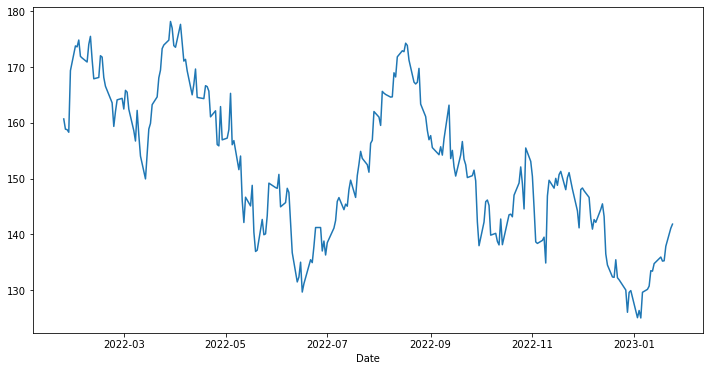

In [44]:
# Plot price evolution
plot_price(d)

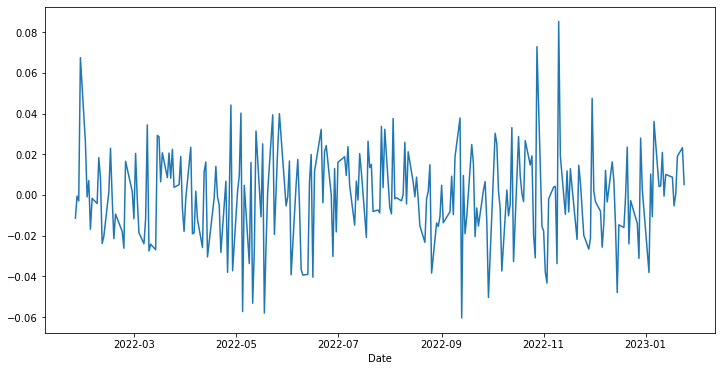

In [36]:
# Daily variation of spot
d_returns = plot_daily_returns(d, log=True)

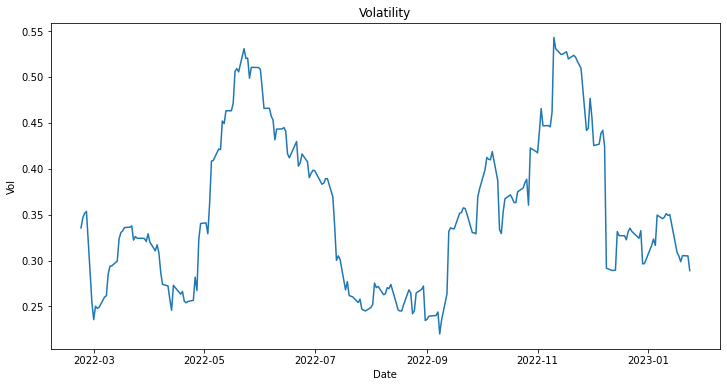

In [37]:
# Historical volatility with a moving window of 20 days
vol = plot_volatility_window(d_returns, 20)

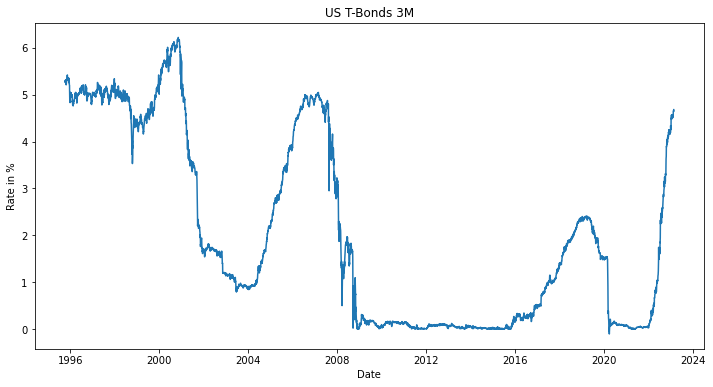

In [10]:
# US Treasury bonds to have a proxy of rfr
ustb = plot_US_TBonds("3M")

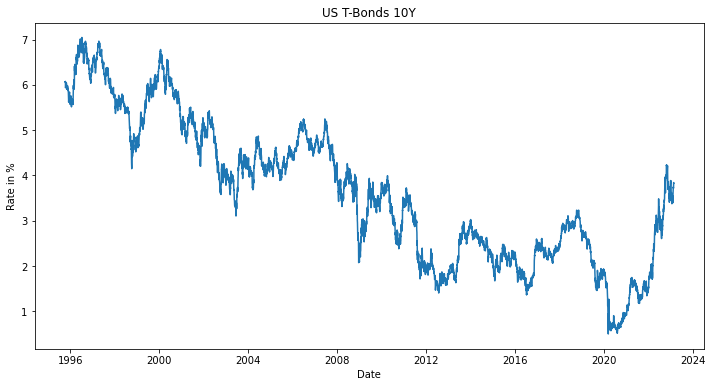

In [12]:
# US Treasury bonds to have a proxy of rfr
ustb = plot_US_TBonds("10Y")

### Estimation of AAPL option <a class="anchor" id="app_oe"></a>

In [45]:
s0 = d["Close"][-1]
K = 150
sigma = vol[-1]
T = 0.25
r = ustb[-1]
params = [s0, K, sigma, T, r]
print(params)

[141.8350067138672, 150, 0.2890831373347052, 0.25, 0.04570000171661377]


In [48]:
print(call(*params), put(*params))

5.520273818874863 11.981269661677345


### Comparison with market prices <a class="anchor" id="app_mp"></a>

In [47]:
get_option_data("AAPL", T, K)

Nearest Expiration date : 2023-04-21


,index,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type
0,19,AAPL230421C00150000,2023-01-24 16:07:38+00:00,150.0,4.78,4.75,4.9,0.480000,11.162790,2411.0,14640,0.286384,False,REGULAR,USD,call
1,67,AAPL230421P00150000,2023-01-24 15:38:17+00:00,150.0,11.90,11.30,11.5,-0.150001,-1.244818,13.0,12307,0.243538,True,REGULAR,USD,put


Call : 
- Price : 5.5 vs 4.8 : OK
- Implied vol : 0.289 vs 0.286 : OK

Put : 
- Price : 11.98 vs 11.90 : OK
- Implied Vol : 0.289 vs 0.243 : OK

In [51]:
implied_vol(s0, K, T, r, 11.90, "put")

0.2861281429694883

In [55]:
implied_vol(s0, K, T, r, 5.1, "call")

0.2737704670355361